# Regularized Polynomial Regression
We'll use the **regularization** in order to avoid two different problems:
- **underfitting**, which is a problem that occurs when we use a model which is too simple to exaplain the data.
- **overfitting**, which is a problem that occurs when we use a model wich is too complex for the given dataset. This approach gives us a very small cost on the training set, but it fails to generalize on unseen data, giving us wrong predictions.

To prevent the *overfitting* problem, a regularization term can be added to the cost function, which depends on a new **hyper-parameter** that weights a **regularization term**. The regularization term imposes a penalty on the complexity of the cost function, in fact the regularization term is as follows:
$$ \lambda \sum_{j=1}^n \theta_j^2 $$
where $\lambda$ is the hyper-parameter and the sum represents the penalty function.

Let's start this experiment by importing some libraries, loading our Boston dataset and introducing the classical function to do the gradient descent and the normal equations without the regularization term.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 

%matplotlib inline

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.random.seed(10)

boston_dataset = load_boston()

In [2]:
def gradient_descent_vectorized(x, y, theta = [[0], [0]], 
                                alpha = 0.01, num_iters = 400, epsilon = 0.0001):
    J_history = np.zeros((num_iters))
    early_stop = -1;
    for k in range(num_iters):
        h = x.dot(theta)
        theta = theta - (alpha/m)*(x.T.dot(h-y))
        J_history[k] = compute_cost_vectorized(x, y, theta)
    return theta, J_history
def compute_cost_vectorized(x, y, theta):
    m = x.shape[0]
    h = x.dot(theta)
    J = (h-y).T.dot(h-y)
    return J/(2*m)
def find_flat(history, epsilon = 0.001):
    for k in range(1, history.size):
        if (history[k-1] - history[k] < epsilon):
            return k;
    return -1
def normal_equations(x, y):
    return np.linalg.pinv(x.T.dot(x)).dot(x.T).dot(y)
def polynomial_features(x, degree):
    for i in range(1, degree):
        label = VARIABLE + '_%d'%(i+1)
        x[label] = x[VARIABLE]**(i+1)
    return x
def feature_normalize(x):
    x_norm = x
    
    mu = np.zeros((1, x.shape[1]))
    sigma = np.zeros((1, x.shape[1]))
    
    mu = np.mean(x, axis = 0) # mean value
    sigma = np.std(x, axis = 0) # std deviation value
    
    for i in range(x.shape[1]):
        x_norm[:,i] = (x[:,i] - mu[i])/sigma[i]
        
    return x_norm, mu, sigma

In [3]:
print(boston_dataset.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


The Boston dataset is a dataset containing the prices of some houses in Boston with respect to some features. 

Let's see what the features in the dataset represents:

In [4]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Let's see the first 5 examples in the dataset:

In [5]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


It's important to note that in the training set shown, there isn't the price, which represents our target feature. 

Let's add it:

In [6]:
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


For each feature, let's see if there is some spurious values (for example a `null` or `NaN` value):

In [7]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Now that we have seen that there is not any invalid value, we can go on with our experiment.

Let's create a DataFrame based on our dataset. This makes possible to shuffle it in an easy way. This technique is used to take a random permutation of the examples, removing the possibility of having a correlation between two subsequent examples in the dataset.

After the shuffle of the dataframe, we will create 3 different dataset from our Boston dataset:
- The first one created is the **training set**, with the 60% of the whole dataset,
- The second one is the **validation set**. It contains the 20% of the Boston dataset,
- The last one is the **test set** which contains the remaing 20% of the Boston dataset.

After the creation of the dataset, we will divide the sets just created into two different portions:
- `X_train`, `X_val`, `X_test`: they contains all the features used to make predictions for each dataset,
- `y_train`, `y_val`, `y_test`: they contains the target features for each portion of the dataset.

After the creation of these values, we will add a column of $1$ to the `X_train`, `X_val`, `X_test`. 

In [8]:
VARIABLE = 'LSTAT'

x = boston[VARIABLE].values.reshape((boston[VARIABLE].shape[0], 1)) #(506, 1)
y = boston['MEDV'].values.reshape((x.shape[0], 1)) #(506, 1)


df = pd.DataFrame(np.concatenate([x, y], axis=1))

# Let's take the training set as the first 60% of the dataset,
# the validation set as the example between the 60% and to 80%,
# the test set will be the remmaining part of the dataset (20%)
train, val, test = np.split(df.sample(frac=1), [int(.6 * len(df)), int(.8*len(df))]) 

# Let's decompose between prediction features and target feature
X_train, y_train = train[0], train[1]
X_val, y_val = val[0], val[1]
X_test, y_test = test[0], test[1]

# Let's do a reshape to create the second dimension
X_train = np.reshape([X_train], (train.shape[0], 1))
y_train = np.reshape([y_train], (train.shape[0], 1))
X_val = np.reshape([X_val], (val.shape[0], 1))
y_val = np.reshape([y_val], (val.shape[0], 1))
X_test = np.reshape([X_test], (test.shape[0], 1))
y_test = np.reshape([y_test], (test.shape[0], 1))

# Let's add the columns of 1 in order to deal with theta_0
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_val = np.c_[np.ones((X_val.shape[0], 1)), X_val]
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]


# Linear regression with regularization
When using the regularization, the cost function represents a tradeoff between the classical cost function and a term that imposes to the parameters not to grow. This behaviour is reached using a regularization term, which is a penalty function on the parameters value. 

It is important to note that the regularization is not applied on the parameter $\theta_0$ as it is a value used to weigth the $x_0$ feature (chosen to be *1* by convention).

The functions implemented in the following code are:
### Regularized cost function
$$J(\theta)=\frac{1}{2m}\bigg[\sum_{i=1}^m\big(h_\theta(x^{(i)})-y^{(i)}\big)^2+\lambda \sum_{j=1}^n \theta_j^2\bigg] $$

It is important to note the regularizion term, because it doesn't include the $\theta_0$ parameter.
### Gradient of the regularized cost function
$$\frac{\partial J(\theta)}{\partial \theta} = \bigg[ \frac{1}{m}\sum_{i=1}^m\big(h_\theta(x^{(i)})-y^{(i)}\big)x^{(i)}+\frac{\lambda}{m} \theta_r\bigg] $$
with:
$$\theta_r = \begin{bmatrix}
    0        \\
    \theta_1  \\
    \dots     \\
    \theta_n
\end{bmatrix}$$
We use $\theta_r$ because we have chosen not to regularize on the first parameter of the parameter vector ($\theta_0$).
### Gradient descent with regularization
The update rule to apply on each iteration is:
$$\theta_0 = \theta_0 - \alpha \frac{1}{m}\sum_{i=1}^m\big(h_\theta(x^{(i)})-y{(i)}\big)x_{0}^{(i)} $$
$$\theta_j = \theta_j - \alpha \bigg[ \frac{1}{m}\sum_{i=1}^m\big(h_\theta(x^{(i)})-y{(i)}\big)x_{j}^{(i)}+\frac{\lambda}{m} \theta_j\bigg] \text{ , for j=1,...,n} $$

Here is shown with greater evidence that **the $\theta_0$ parameter is not regularized**.

The second equation can be rewritten as:
$$\theta_j = \theta_j \big( 1-\alpha \frac{ \lambda}{m} \big) - \alpha  \frac{1}{m}\sum_{i=1}^m\big(h_\theta(x^{(i)})-y{(i)}\big)x_{j}^{(i)} \text{ , for j=1,...,n} $$
The multiplicative factor of $\theta_j$ is usually a value less than $0$. Consequently, we can state that the regularization term is just a way to shrink the parameter vector at each iteration.
### Normal equation considering the regularization
As we did in the previous experiments, the value that minimize the cost function can be found analytically by means of the **normal equations**. In this case, considering the regularized cost function, it can be shown that the regularized normal equations are:
$$\theta = \Big( X^TX+\lambda \begin{bmatrix}
    0       & 0 & 0 & \dots & 0 \\
    0       & 1 & 0 & \dots & 0 \\
    0       & 0 & 1 & \dots & 0 \\
    0       & 0 & 0 & \dots & 1
\end{bmatrix} \Big)X^Ty$$
where the matrix is a $(n+1)\times(n+1)$ matrix.
This approach has some advantages over the gradient descent method:
- there is no need to do the feature scaling in case of features values with different scales (this always happen when dealing with polynomial regression),
- there is no need to choose the learning rate hyper-parameter needed to the gradient descent algorithm because there are no iterations at all.

The main disadvantage is the need to calculate the inverse of a matrix, which is very resource consuming and computation intensive. 

In [9]:
def compute_cost_reg(theta, x, y, lamda = 0):
    h = x.dot(theta)
    m = x.shape[0]
    J = np.sum((h-y)**2) / (2 * m)
    theta_1 = theta
    theta_1[0] = 0
    J = J + lamda / (2 * m) * np.sum(theta_1 ** 2)
    return J

def gradient_reg(theta, x, y, lamda = 0):
    m = x.shape[0]
    theta_r = theta
    theta_r[0] = 0
    h = x.dot(theta)
    grad = (x.T.dot(h-y) / m) + (lamda/m)*theta_r
    return grad.flatten()

def gradient_descent_reg(theta, X, y, _lambda=0, alpha = 0.001, num_iters = 20000, epsilon = 0.0001):
    for k in range(num_iters):
        grad = gradient_reg(theta, X, y, _lambda).reshape((theta.shape[0],1))
        theta = theta - np.multiply(alpha, grad)
    return theta

def normal_equation_reg(x, y, lamda):
    matrix_for_regularization = np.identity(x.shape[1])
    matrix_for_regularization[0][0] = 0
    inverse = np.linalg.pinv(np.add(x.T.dot(x), np.multiply(lamda, matrix_for_regularization)))
    return (inverse.dot(x.T)).dot(y)
    

# Part 1. Comparing different degrees of hypothesis 
In this part of the excercise we will compare different degrees of hypothesis function. To choose the best hypothesis function we will calculate the parameters vector $\theta$ using the non-regularized cost function. We will complete two steps: 
1. Calculate the parameter vector using a given degree of the hypotesis function on the training set and calculate the cost on the same set;
2. Calculate the cost function on the validation set using the $\theta$ value calculated at the previous step.

We will draw a graph with the costs calculated in order to facilitate the analysis.

We will first train the different models, starting from a degree of 1 to degree 26:

In [10]:
dataframe = pd.DataFrame(X_train[:,1], columns=[VARIABLE])
dataframe_val = pd.DataFrame(X_val[:,1], columns=[VARIABLE])

costs_train, costs_val = [], []
_thetas_train = []
for degree in range(1, 26):
    
    # Calculate the features for the training and the validation set 
    new_data = polynomial_features(dataframe, degree) 
    new_data_val = polynomial_features(dataframe_val, degree) 
    _x_train = np.concatenate([np.ones((dataframe.shape[0], 1)), new_data], axis=1)
    _x_val = np.concatenate([np.ones((dataframe_val.shape[0], 1)), new_data_val], axis=1)
    
    # Train the model
    theta = normal_equations(_x_train, y_train)
    
    # Calculate the cost on the training set and save it
    _cost_train = compute_cost_vectorized(_x_train, y_train, theta)
    costs_train.append(_cost_train[0][0])
    
    # Calculate the cost on the validation set and save it
    _cost_val = compute_cost_vectorized(_x_val, y_val, theta)
    costs_val.append(_cost_val[0][0])


We can now plot the costs calculated in the previous step:

(13, 22)

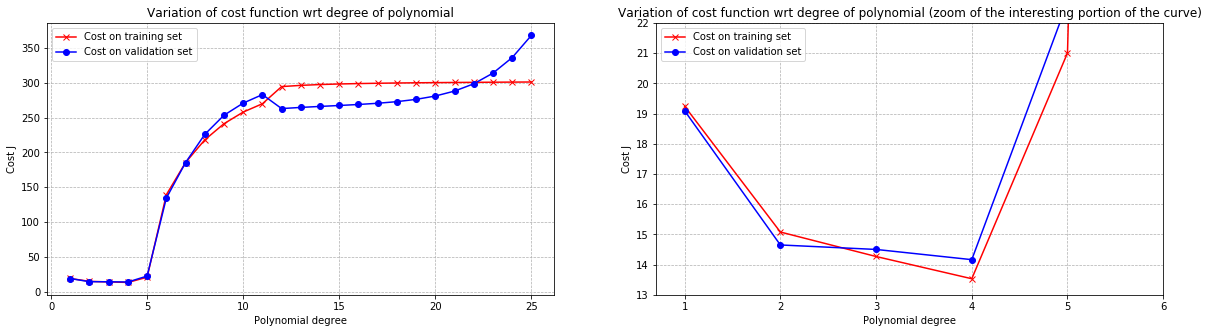

In [11]:
# Plot gradient descent
plt.figure(figsize=(20, 5))

# Create stuff to show
labels = np.arange(1, 26)

# First subplot (left plot)
plt.subplot(1, 2 , 1)
plt.plot(labels, costs_train, '-x', c='r', label='Cost on training set')
plt.plot(labels, costs_val, '-o', c='b', label='Cost on validation set')
plt.grid(linestyle='--', linewidth=.7)

plt.title('Variation of cost function wrt degree of polynomial')
plt.xlabel('Polynomial degree')
plt.ylabel('Cost J')
plt.legend(loc=2);


# Second subplot
plt.subplot(1, 2 , 2)
plt.plot(labels, costs_train, '-x', c='r', label='Cost on training set')
plt.plot(labels, costs_val, '-o', c='b', label='Cost on validation set')
plt.grid(linestyle='--', linewidth=.7)

plt.title('Variation of cost function wrt degree of polynomial (zoom of the interesting portion of the curve)')
plt.xlabel('Polynomial degree')
plt.ylabel('Cost J')
plt.legend(loc=2)

plt.xlim(0.7,6)
plt.ylim(13,22)




From this graph, it can be seen that for a $4^{th}$ degree hypothesis function, the cost on the training set and the one on the validation set is minimized, which means that the correct choice for the hypothesis is that one.

On the other hand, it can be seen that for the lower order models, the two costs are higher that the previous one, wich means that we have a problem with **high bias**, which means the we are **underfitting** the model. For the higher degrees, the cost calculated on the training set is almost the same, while the one on the validation set becomes higher and higher: this is a situation where we're **overfitting** the model, which means that we have a problem with **high variance**.
# Part 2. Choice of the regularization parameter
In this part of the experiment we will use the hypothesis function as follows:
$$h_\theta(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \theta_4 x^4$$
This choice of hypothesis function is based on the considerations done in the previous section.

In this section, we will try to find the best value of regularization parameter $\lambda$ in order to avoid the overfitting on the training set.

To do so, we will apply the **regularized normal equation** using several values of the $\lambda$ parameter and choosing the one which performs better.

Let's create an array with all the $\lambda$ parameter values. We will start from a value of $0.01$, and the we will double up the value untill a threshold value is encountered (in this example the threshold is 100).

In [12]:
selected_degree = 4

lamdas = [0, .01]
lamda = .01
while lamda <= 100:
    lamda = lamda*2
    lamdas.append(lamda)
print("We'll try these values of lambda to see how the cost function behaves:\n{}".format(lamdas))

We'll try these values of lambda to see how the cost function behaves:
[0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24, 20.48, 40.96, 81.92, 163.84]


We can now create the training and the validation set upon wich we can operate:

In [13]:
dataframe = pd.DataFrame(X_train[:,1], columns=[VARIABLE])
new_data = polynomial_features(dataframe, selected_degree)
x_train_part_2 = np.concatenate([np.ones((dataframe.shape[0], 1)), new_data], axis=1)

dataframe = pd.DataFrame(X_val[:,1], columns=[VARIABLE])
new_data = polynomial_features(dataframe, selected_degree)
x_val_part_2 = np.concatenate([np.ones((dataframe.shape[0], 1)), new_data], axis=1)

Let's test on both datasets the different values of the regularization parameter and let's keep track of the cost function

In [14]:
costs_train, costs_val = [], []

# Iterate over all lambda values
for lamda in lamdas:
    
    # Train the model using a value of lambda at a time
    _theta_train = normal_equation_reg(x_train_part_2, y_train, lamda)
    
    # Calculate the cost on the training set and save it
    _cost_train = compute_cost_vectorized(x_train_part_2, y_train, _theta_train)
    costs_train.append(_cost_train[0][0])
    
    # Calculate the cost on the validation set and save it
    _cost_val = compute_cost_vectorized(x_val_part_2, y_val, _theta_train)
    costs_val.append(_cost_val[0][0])

We can now plot the costs on the training set and the validation set with respect to the $\lambda$ values:

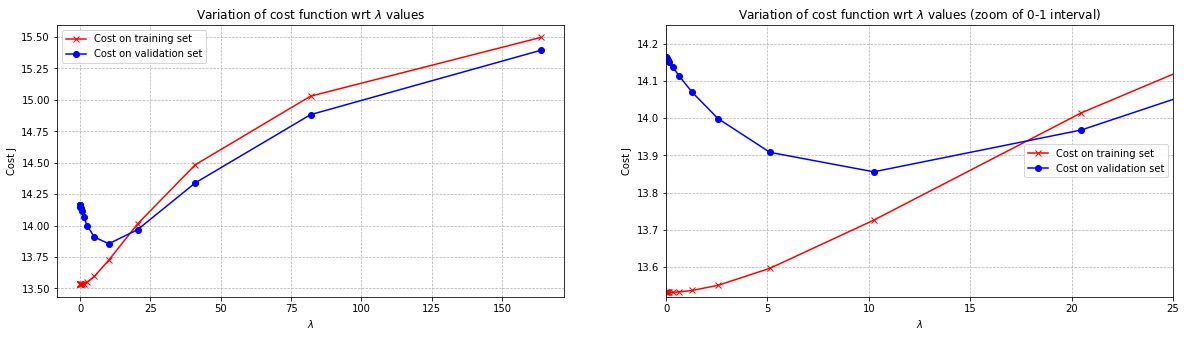

In [15]:
# Plot gradient descent
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(lamdas, costs_train, '-x', c='r', label='Cost on training set')
plt.plot(lamdas, costs_val, '-o', c='b', label='Cost on validation set')

plt.title('Variation of cost function wrt $\lambda$ values')
plt.xlabel('$\lambda$')
plt.ylabel('Cost J')
plt.legend(loc=2);
plt.grid(linestyle='--', linewidth=.7)

plt.subplot(1, 2, 2)
plt.plot(lamdas, costs_train, '-x', c='r', label='Cost on training set')
plt.plot(lamdas, costs_val, '-o', c='b', label='Cost on validation set')

plt.title('Variation of cost function wrt $\lambda$ values (zoom of 0-1 interval)')
plt.xlabel('$\lambda$')
plt.ylabel('Cost J')
plt.legend(loc=5)
plt.xlim(-.02, 25)
plt.ylim(13.52, 14.25)
plt.grid(linestyle='--', linewidth=.7, which='both')


The best choice of the regularization parameter is the choice which minimizes the cost on the validation set. The best value is $\lambda=10.24$. 

In the left graph, two behaviours can be seen:
1. On the smaller values of $\lambda$ there is a high cost calculated on the validation set, even if it's the smallest possible on the training set. This means that we have a problem with **high variance**, which is a synonymous of **overfitting**;
2. On the other hand, for the higher values of $\lambda$, the costs on the training set and on the validation set are both high and comparable. This means that we have a problem with **high bias**, which is a synonymous of the **underfitting** problem.

# Part 3. Diagnosing problems with the learning curves
By now, we have chosen the degree of the hypothesis function and the best value possible for the regularization parameter. The last step we have to do in this experiment is to diagnose a problem with **high variance** or **high bias** based on the **learning curves**, which are a way to show how the cost functions go with respect to the number of training examples used to train the model.

In order to implement this phase, we will have to start by taking just a training example, calculate the parameter $\theta$ using the normal equations and use this value to calculate the cost on the training set and on the validation set. We will then modify the number of the training examples by incrementing the value by 1 and we will repeat the same procedure again. We will stop when the number of the training examples considered will represents the whole training set.

Let's start by doing so:

In [16]:
lamda = 10.24
costs_train, costs_val, training_examples = [], [], []

for num_examples in range(1, X_train.shape[0]):
    
    # Keep track of the number of training examples used to train the model
    training_examples.append(num_examples)
    
    # Let's take the first part of the training set
    x_train = X_train[:num_examples]
    
    # Create the dataset used for the training phase
    dataframe = pd.DataFrame(x_train[:,1], columns=[VARIABLE])
    new_data = polynomial_features(dataframe, selected_degree)
    x_train = np.concatenate([np.ones((dataframe.shape[0], 1)), new_data], axis=1)
    
    # Let's train the model
    _theta = normal_equation_reg(x_train, y_train[:num_examples], lamda)
    
    # Calculate the cost on the training set and save it
    _cost_train = compute_cost_vectorized(x_train, y_train[:num_examples], _theta)
    costs_train.append(_cost_train[0][0])
    
    # Calculate the cost on the validation set and save the value into an array
    _cost_val = compute_cost_vectorized(x_val_part_2, y_val, _theta)
    costs_val.append(_cost_val[0][0])

Let's plot the costs with respect to the number of the training examples used in the training phase:

(12.5, 15.5)

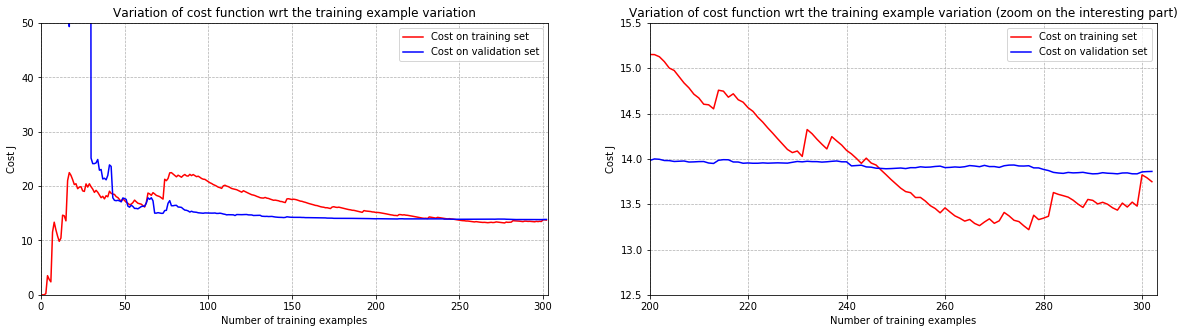

In [17]:
# Plot gradient descent
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(training_examples, costs_train, '-', c='r', label='Cost on training set')
plt.plot(training_examples, costs_val, '-', c='b', label='Cost on validation set')

plt.title('Variation of cost function wrt the training example variation')
plt.xlabel('Number of training examples')
plt.ylabel('Cost J')
plt.legend(loc=1);
plt.grid(linestyle='--', linewidth=.7)

plt.xlim(0, 303)
plt.ylim(0,50)


plt.subplot(1, 2, 2)
plt.plot(training_examples, costs_train, '-', c='r', label='Cost on training set')
plt.plot(training_examples, costs_val, '-', c='b', label='Cost on validation set')

plt.title('Variation of cost function wrt the training example variation (zoom on the interesting part)')
plt.xlabel('Number of training examples')
plt.ylabel('Cost J')
plt.legend(loc=1);
plt.grid(linestyle='--', linewidth=.7)

plt.xlim(200, 303)
plt.ylim(12.5,15.5)

In the graphs above, it can be seen how the cost functions behaves when the number of the training examples varies.

Initially, when the number of the training examples is low, the cost on the training set is very low (it's easy to overfit the data in such a case), while the cost on the validation set is very high since the model overfits the training set and doesn't generalize on unseen data.

When the number of training examples increases, the model starts to fit the data in an optimal way, increasing the cost on the training set (because it cannot overfit the data thanks to the regularization term) but lowering the cost on the validation set (wich represents the unseen events at the moment).

After an exact point, even if the number of training examples increases, the value of the cost function doesn't decrease, which means that adding new training examples doesn't improve the model. This event is usually related with a problem with **high bias**, but this is not the case since the value of the cost function is low. An other possibility would be to have the two curves to be one far from the other with a gap between them. In this case adding new training examples would be prefered since the cost function on the validation set would decrease: this would be a clear indication of a problem with **high variance**.  